In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
import xgboost as xgb

from sklearn.multioutput import MultiOutputRegressor
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler



# Introduction

Welcome to this notebook! This simple document showcases the power of Machine Learning in simulating and optimizing the behavior of a portfolio of assets to support optimal decision-making.

In this analysis, we will use historical data from five major technology companies—***Apple, Microsoft, AMD, Nvidia, and Google***—retrieved via **yfinance**. Our goal is to simulate the performance of a portfolio based on these assets and apply financial techniques for optimization.

The steps in this notebook are as follows:

**1) Data Analysis:Perform an in-depth analysis of the historical data to understand the risk and return characteristics of each asset.**

**2) Portfolio Optimization using Modern Portfolio Theory (MPT): Optimize the portfolio weights to achieve the best risk-return balance.**

**3) Simulating Portfolio Behavior for 2022: Use the optimized portfolio weights to simulate the portfolio's performance in 2022, based on the data from 2021.**


Through these steps, we will illustrate how machine learning and financial modeling can be applied to real-world data for effective portfolio management and decision-making.

# XGB Modelisation

In [ ]:
data = yf.download(['AAPL', 'MSFT', 'AMD', 'NVDA', 'GOOG'], start='2021-01-01', end='2022-01-01')
prices = data['Adj Close']
returns = prices.pct_change().dropna()

[*********************100%***********************]  5 of 5 completed


## Calculating weights for each assets

In [ ]:
X = returns.shift(1).dropna()
y = returns.shift(-1).dropna()

X, y = X.align(y, join='inner', axis=0)


xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
multi_output_model = MultiOutputRegressor(xg_reg)
multi_output_model.fit(X, y)

predicted_returns = multi_output_model.predict(X)
mse = mean_squared_error(y, predicted_returns)
rmse = np.sqrt(mse)
print(f"Multi-Output XGBoost RMSE: {rmse}")

Multi-Output XGBoost RMSE: 0.0038351456784648536


In [ ]:
def portfolio_volatility(weights, cov_matrix):
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    return np.sqrt(portfolio_variance)

def optimize_portfolio(predicted_returns, cov_matrix):
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = [(0, 1) for _ in range(predicted_returns.shape[1])]
    initial_weights = np.array([1.0 / predicted_returns.shape[1]] * predicted_returns.shape[1])  # Equal weighting
    optimal_result = minimize(portfolio_volatility, initial_weights, args=(cov_matrix),
                              method='SLSQP', bounds=bounds, constraints=constraints)
    return optimal_result.x


predicted_cov_matrix = np.cov(predicted_returns, rowvar=False)
optimal_weights = optimize_portfolio(predicted_returns, predicted_cov_matrix)


predicted_portfolio_returns = np.dot(predicted_returns, optimal_weights)

print(f"Optimal weight: {optimal_weights}")

Optimal weight: [3.08167612e-01 2.77555756e-17 3.30778705e-01 3.61053683e-01
 0.00000000e+00]


## Training Model With historical data from 2021

Multi-Output XGBoost RMSE: 0.0038351456784648536


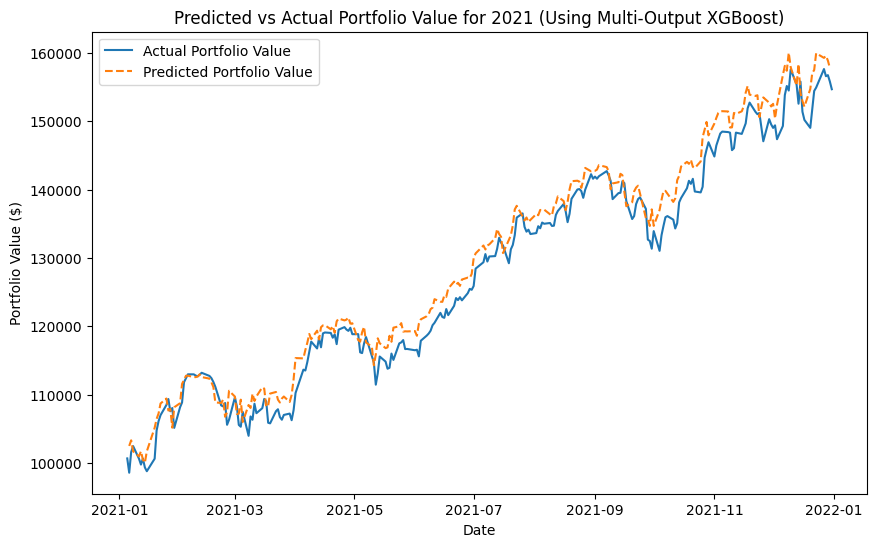

In [ ]:
X = returns.shift(1).dropna()
y = returns.shift(-1).dropna()

X, y = X.align(y, join='inner', axis=0)


xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
multi_output_model = MultiOutputRegressor(xg_reg)
multi_output_model.fit(X, y)

predicted_returns = multi_output_model.predict(X)
mse = mean_squared_error(y, predicted_returns)
rmse = np.sqrt(mse)
print(f"Multi-Output XGBoost RMSE: {rmse}")

portfolio_returns_actual = returns.dot(optimal_weights)
initial_portfolio_value = 100000
portfolio_values_actual = initial_portfolio_value * (1 + portfolio_returns_actual).cumprod()

predicted_portfolio = predicted_returns.dot(optimal_weights)
predicted_portfolio_values = initial_portfolio_value * (1 + predicted_portfolio).cumprod()

plt.figure(figsize=(10, 6))
plt.plot(returns.index, portfolio_values_actual, label='Actual Portfolio Value')
plt.plot(returns.index[1:-1], predicted_portfolio_values, label='Predicted Portfolio Value', linestyle='dashed')
plt.title('Predicted vs Actual Portfolio Value for 2021 (Using Multi-Output XGBoost)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()

## Transfer-learning to predict the Behaviour for 1 week window

### Model Description

In this notebook, we use a pre-trained model on historical data to predict weekly asset returns. The model utilizes the return values from the previous week to forecast the returns for the upcoming week. After making each new prediction, we update the model using the actual returns from the past week to ensure it remains accurate and adapts to changing market conditions.

#### Illustration:

Let’s define:

- $ R_{i} $ as the actual return values for week $ i $
- $ P_i $ as the predicted return values for week $ i $
- $ G_i $ as the model used to predict $ P_i $

The prediction process works as follows:

1. The predicted return for week $ i $, $ P_i $, is obtained using the model $ G_i $ and the actual returns from the previous week, $ R_{i-1} $. Mathematically, this can be written as:
   $$
   P_i = G_i(R_{i-1})
  $$
   Here, the model $ G_i $ uses the past week's actual returns to predict the returns for the next week.

2. Once week $ i $ has passed and the actual return values $ R_i $ are observed, we update the model to create a new model $ G_{i+1}$. The new model is trained on the $ R_i $, allowing it to learn from the latest market behavior.

3. The updated model $ G_{i+1} $ is then used to predict the returns for the next week:
   $$
   P_{i+1} = G_{i+1}(R_i)
   $$
   This process is repeated iteratively for each new week, continually refining the model with the most recent data.


### Pretrain with 2021 data

In [ ]:
data = yf.download(['AAPL', 'MSFT', 'AMD', 'NVDA', 'GOOG'], start='2021-01-01', end='2022-01-01')
prices = data['Adj Close']
returns = prices.pct_change().dropna()


[*********************100%***********************]  5 of 5 completed


In [ ]:
weekly_returns_2021 = returns.resample('W').apply(lambda x: (1 + x).prod() - 1).dropna()


X = weekly_returns_2021.shift(1).dropna()  # Lagged returns as features
y = weekly_returns_2021.shift(-1).dropna()  # Next week's returns for all assets
X, y = X.align(y, join='inner', axis=0)



xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
multi_output_model = MultiOutputRegressor(xg_reg)
multi_output_model.fit(X, y)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))

### Predicting Portfolio Behaviour with one week window

In [ ]:
data_2022 = yf.download(['AAPL', 'MSFT', 'AMD', 'NVDA', 'GOOG'], start='2022-01-01', end='2023-01-01')
prices_2022 = data_2022['Adj Close']
returns_2022 = prices_2022.pct_change().dropna()
weekly_returns_2022 = returns_2022.resample('W').apply(lambda x: (1 + x).prod() - 1).dropna()


predicted_returns_2022 = []


last_week_data = weekly_returns_2021.iloc[-1].values.reshape(1, -1)

# Weekly prediction and retraining loop
for i in range(len(weekly_returns_2022)):

    next_week_returns = multi_output_model.predict(last_week_data)[0]
    predicted_returns_2022.append(next_week_returns)

    actual_returns_current_week = weekly_returns_2022.iloc[i].values.reshape(1, -1)
    last_week_data = actual_returns_current_week

    if i <= 2:
        combined_returns = pd.concat([weekly_returns_2021.iloc[-3+i:-1], weekly_returns_2022.iloc[:i+1]])
    else:
        combined_returns = weekly_returns_2022.iloc[i-2:i+1]


    new_X = combined_returns.shift(1).dropna()
    new_y = combined_returns.dropna()



    new_X, new_y = new_X.align(new_y, join='inner', axis=0)


    multi_output_model.fit(new_X.iloc[1:2], new_y.iloc[1:2])

[*********************100%***********************]  5 of 5 completed


In [ ]:
weights = optimal_weights
predicted_returns_2022 = np.array(predicted_returns_2022)
predicted_portfolio_returns_2022 = predicted_returns_2022.dot(weights)

portfolio_returns_actual = weekly_returns_2022.dot(weights)

initial_portfolio_value = 100000
portfolio_values_actual = initial_portfolio_value * (1 + portfolio_returns_actual).cumprod()
predicted_portfolio_values = initial_portfolio_value * (1 + predicted_portfolio_returns_2022).cumprod()
predicted_portfolio_returns_2022 = pd.Series(predicted_portfolio_returns_2022, index=weekly_returns_2022.index)

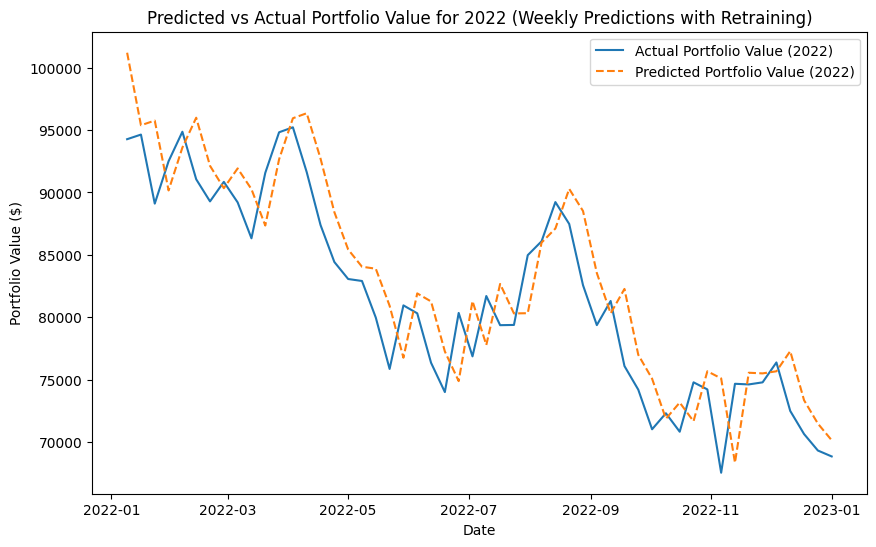

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(weekly_returns_2022.index, portfolio_values_actual, label='Actual Portfolio Value (2022)')
plt.plot(weekly_returns_2022.index, predicted_portfolio_values, label='Predicted Portfolio Value (2022)', linestyle='dashed')
plt.title('Predicted vs Actual Portfolio Value for 2022 (Weekly Predictions with Retraining)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()

In [ ]:


def calculate_financial_metrics(returns, risk_free_rate=0.038/52):

    mean_return = returns.mean()
    std_dev = returns.std()


    sharpe_ratio = (mean_return - risk_free_rate) / std_dev

    confidence_level = 0.95
    var_95 = returns.quantile(1 - confidence_level)


    cvar_95 = returns[returns <= var_95].mean()


    cumulative_returns = (1 + returns).cumprod()
    running_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - running_max) / running_max
    max_drawdown = drawdown.min()


    return_on_risk = mean_return / std_dev


    metrics = {
        "Mean Return": mean_return,
        "Standard Deviation": std_dev,
        "Sharpe Ratio": sharpe_ratio,
        "VaR (95%)": var_95,
        "CVaR (95%)": cvar_95,
        "Max Drawdown": max_drawdown,
        "Return on Risk": return_on_risk
    }
    return metrics

metrics_actual = []
metrics_predicted = []

for i in range(len(weekly_returns_2022)):

    metrics_actual.append(calculate_financial_metrics(portfolio_returns_actual.iloc[:i+1]))


    metrics_predicted.append(calculate_financial_metrics(predicted_portfolio_returns_2022[:i+1]))


df_metrics_actual = pd.DataFrame(metrics_actual, index=weekly_returns_2022.index)
df_metrics_predicted = pd.DataFrame(metrics_predicted, index=weekly_returns_2022.index)


<Figure size 1400x800 with 0 Axes>

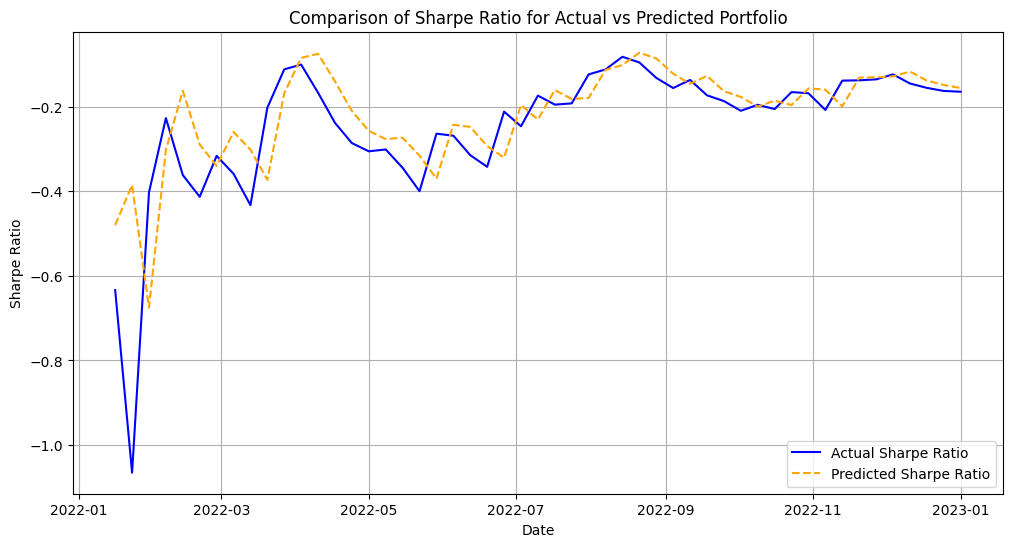

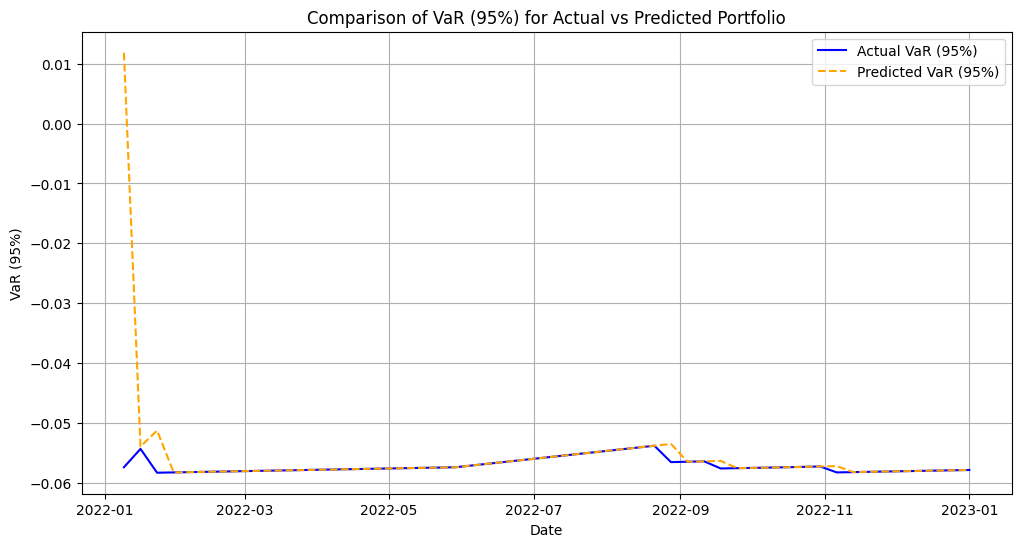

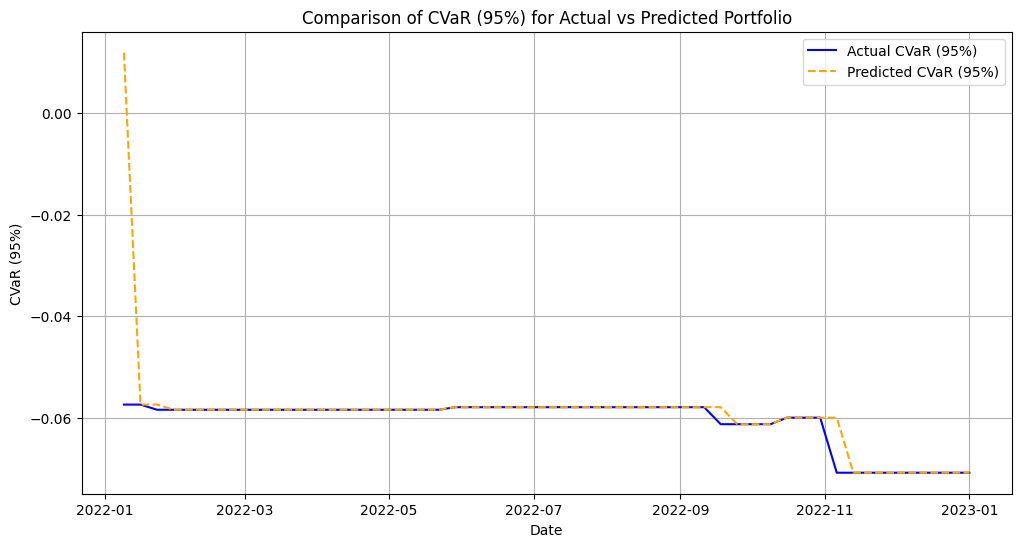

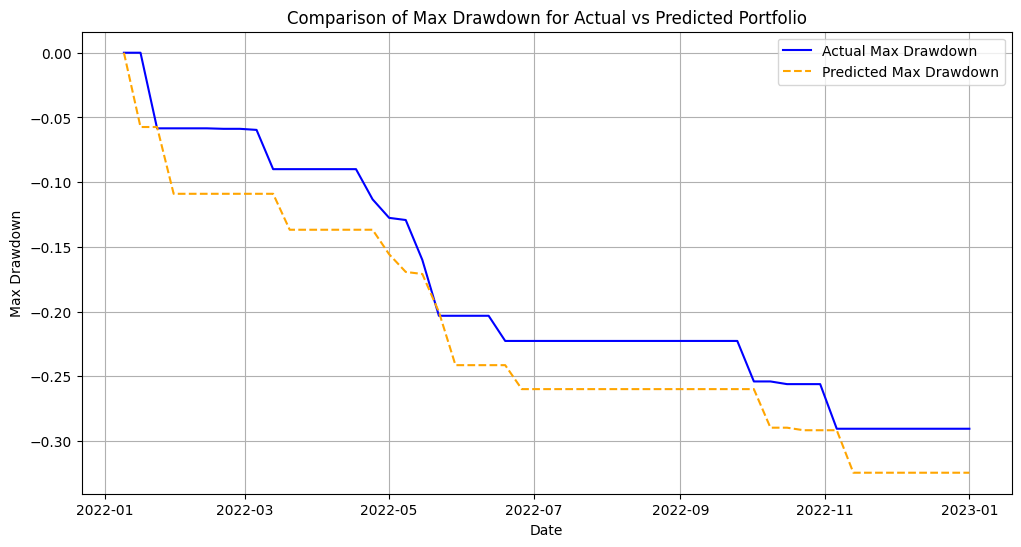

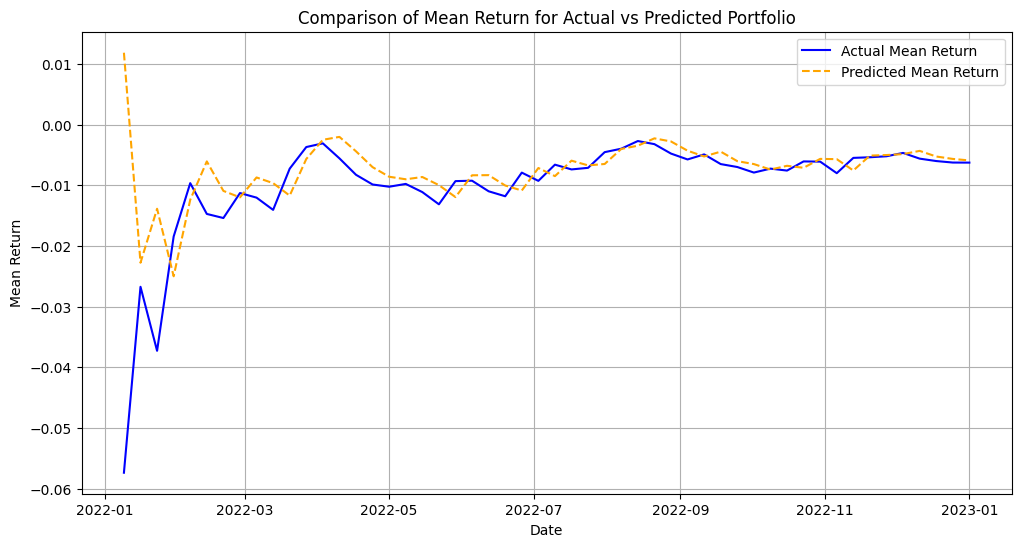

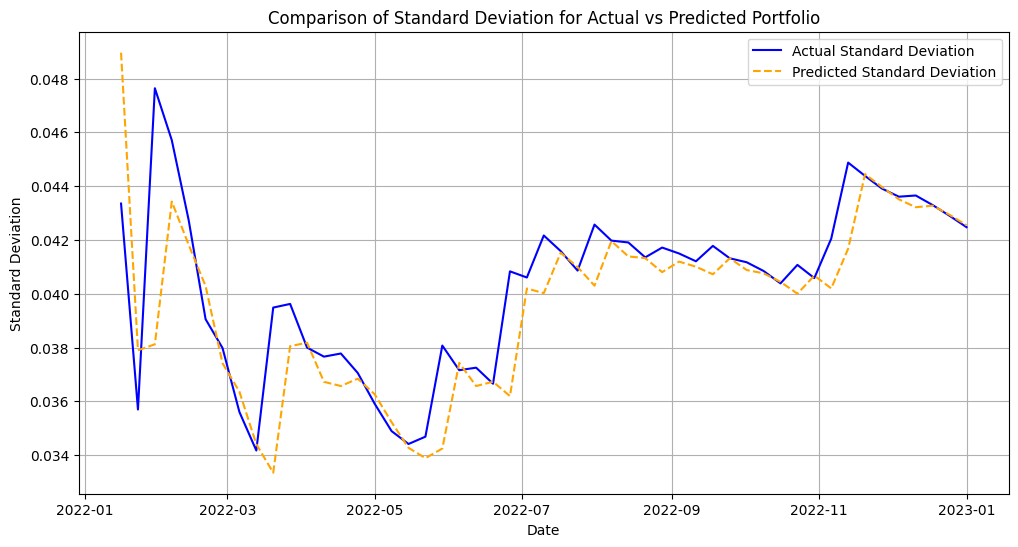

In [ ]:
metrics_to_plot = [
    "Sharpe Ratio", "VaR (95%)", "CVaR (95%)", "Max Drawdown", "Mean Return", "Standard Deviation"
]


plt.figure(figsize=(14, 8))
for metric in metrics_to_plot:
    plt.figure(figsize=(12, 6))
    plt.plot(df_metrics_actual.index, df_metrics_actual[metric], label=f'Actual {metric}', color='blue')
    plt.plot(df_metrics_predicted.index, df_metrics_predicted[metric], label=f'Predicted {metric}', linestyle='dashed', color='orange')
    plt.title(f'Comparison of {metric} for Actual vs Predicted Portfolio')
    plt.xlabel('Date')
    plt.ylabel(metric)
    plt.legend()
    plt.grid()
    plt.show()
